# k-Nearest Neighbor Classification and The Importance of Separate Test Data

Learning Objectives:
* Students will learn about and apply the k-nearest neighbors algorithm for classification.
* Students will understand the importance of and practice the separation of training and test data to test for model overfitting.
* Students will learn of the tradeoff spectrum from high-bias, low-variance, interpretable, simple models to low-bias, high-variance, uninterpretable, complex models.

Before class:
* Introductory section of the Wikipedia [k-Nearest Neighbors Algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) article
* Section 2.2 of James et al., [An Introduction to Statistical Learning with Applications in R](http://faculty.marshall.usc.edu/gareth-james/ISL/) _Download the outstanding free PDF textbook. If this course used the R programming language, this would be a core text for us.  Don't concern yourself so much with the mathematical notation, but seek to understand the core tradeoffs we'll be observing here and with other models in this course._
* Read below up to (but not including) the section marked In Class.

Optional:
* If you have the time, go back and read section 2.1 of [An Introduction to Statistical Learning with Applications in R (a.k.a. ISLR)](http://faculty.marshall.usc.edu/gareth-james/ISL/).  _The introductory chapters provide excellent perspective on the tasks and challenges of Data Science._
* Enjoy this [Michael Littman, Charles Isbell Overfitting Music Video](https://www.youtube.com/watch?v=DQWI1kvmwRg) a parody of [Michael Jackson's Thriller](https://www.youtube.com/watch?v=sOnqjkJTMaA).

In class:
* We will work together on the exercises in section "In Class".

Homework after class:
* Complete the section labeled "Homework" below before the next class when it will be collected.


# k-Nearest Neighbors

Recall that the supervised learning task of classification is build a model that maps inputs to classes (categories) well given a set of input-class pairs.  We first generate and display data generated in a way similar to that of the example of ISLR 2.2.

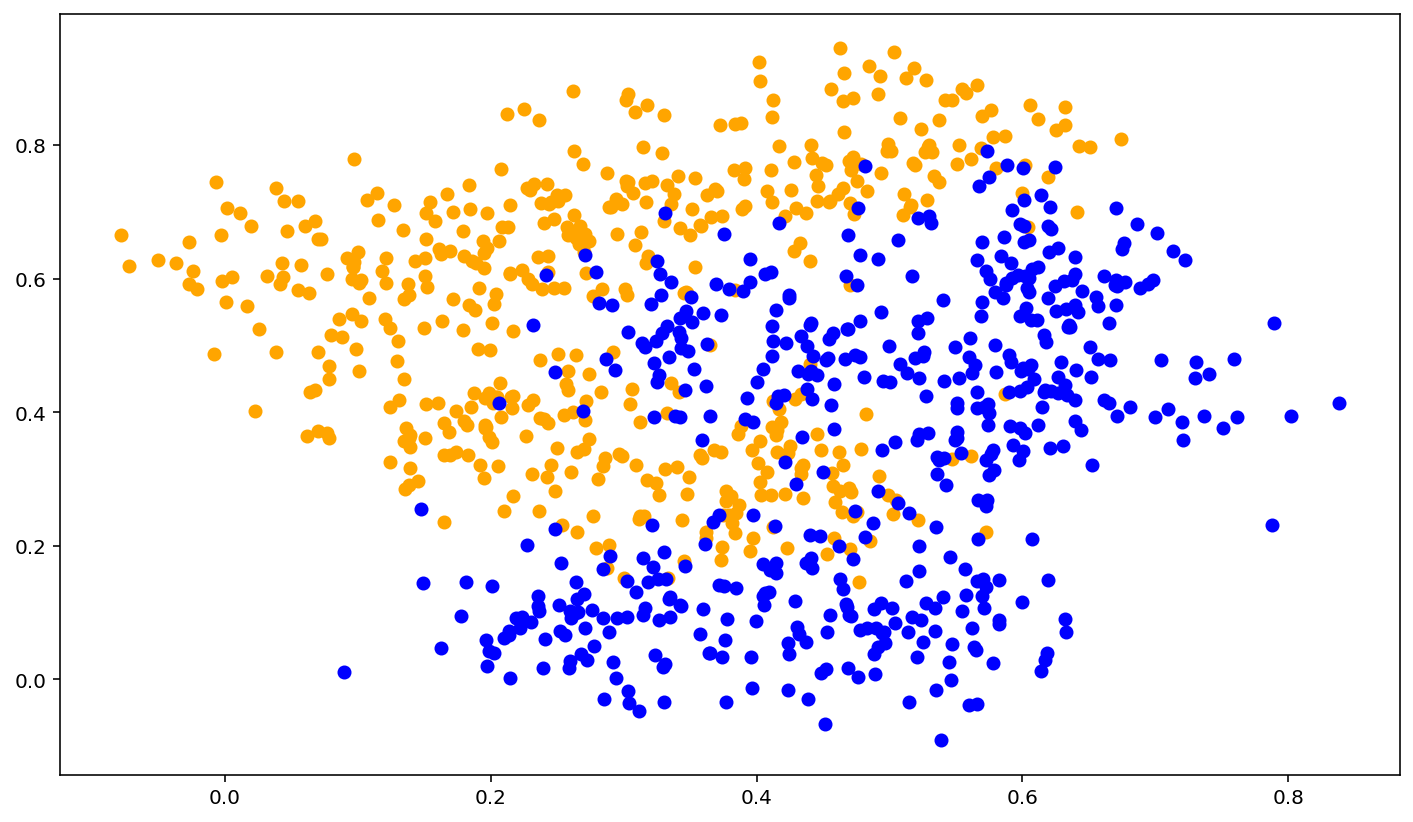

,x1,x2,y
0,0.736644,0.394326,1
1,0.162748,0.047812,1
2,0.214820,0.606934,0
3,0.245322,0.714742,0
4,0.438145,0.498891,1


In [1]:
import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import math
import random

# NOTE: It is not necessary for you to understand this code at this point.  It is supplied for the curious.

# We begin by importing our entire pseudorandom number generator (PRNG) module and giving it a "seed" for reproducability:
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# We generate 1000 shuffled 2D data points sampled from  10 normally-distributed clusters 
#   with half of clusters labeled "0" (orange) and half labeled "1" (blue).

stdev = 0.075
num_clusters = 10
# centroids = [[random(), random()] for i in range(num_clusters)] # random centroids had too much overlap for this illustration
centroids = [[.5, .8], [.5, .1], [.3, .7], [.6, .6], [.1, .6], [.4, .5], [.4, .3], [.6, .4], [.2, .4], [.3, .1]]
# print(centroids)
data = [[np.random.normal(loc=centroids[i % num_clusters][0], scale=stdev),
         np.random.normal(loc=centroids[i % num_clusters][1], scale=stdev),
         str((i % num_clusters) % 2)] for i in range(1000)]
random.shuffle(data, random.random)

x1 = [x[0] for x in data if x[2] == '0']
x2 = [x[1] for x in data if x[2] == '0']
plt.scatter(x1, x2, color='orange')
x1 = [x[0] for x in data if x[2] == '1']
x2 = [x[1] for x in data if x[2] == '1']
plt.scatter(x1, x2, color='blue')
plt.show()

df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])
df.head()


The [k-Nearest Neighbors Algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (k-NN) finds the $k$ closest points to an input point according to a metric (e.g. Euclidean distance) and forms a classification or regression prediction from those points.  Whereas linear regression is a _parametric_ method that learns parameters for its model (e.g. y-intercept, coefficients), k-NN is an instance-based (i.e. working directly from the data) and lazy-learning (i.e. computing results on demand) method that is both flexible and more computationally demanding on the application side of computation.

To compute a probability of whether a point is in class (category) $c$, k-NN finds the $k$ closest points and computes the fraction of those points that are in class $c$.  To predict a classification, it predicts the class with the highest probability.  Suppose there is a tie, e.g. $k=2$ and each of the two nearest neighboring points belong to different classes.  There are many ways people break ties in practice:
* arbitrarily
* randomly
* weighting the "votes" according to nearness of neighbors (inverse distance or inverse distance squared) of neighbors
* incrementing $k$ for the prediction until the tie is broken, i.e. looking to next neighbor until the tie is broken

We'll now build a k-NN classifier with the default $k=5$ and visualize the classification.

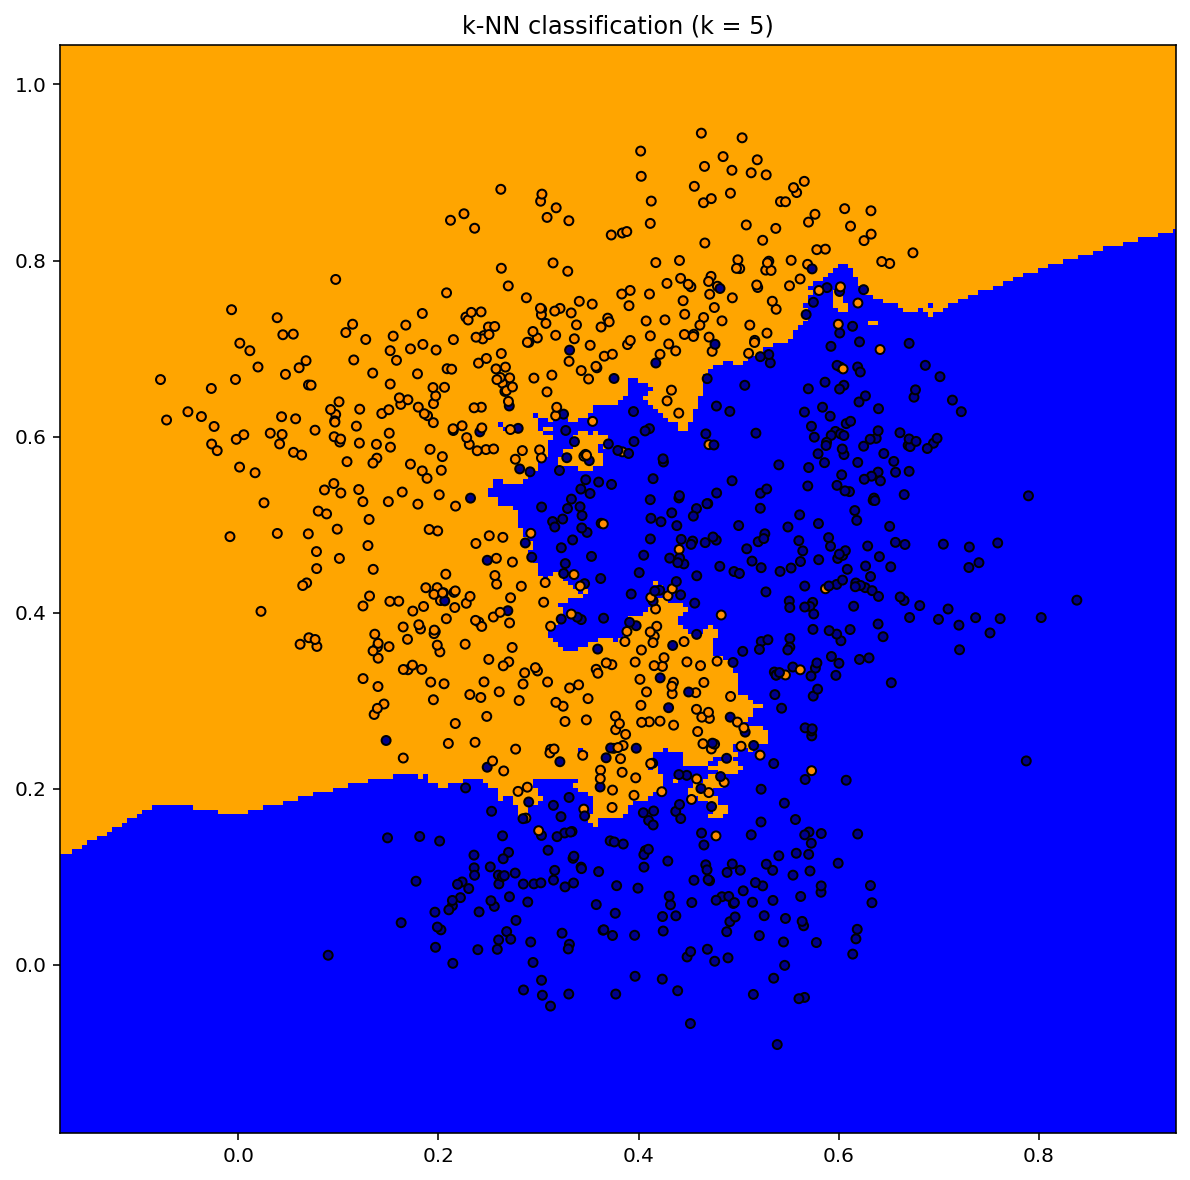

In [2]:
# drawing from example: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

# Create color maps
cmap_light = ListedColormap(['orange', 'blue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

# Create input/output dataframe slices
X = df[['x1', 'x2']]
y = df['y'].apply(lambda y: 1 if y == '1' else 0)  # Note: these values need to be 0-based indices to the colormap colors.
                                                   # If y values go beyond the indices of the colormaps, you'll get a "TypeError: iteration over a 0-d array"

# Build the k-NN classifier
clf = KNeighborsClassifier()
clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .005  # step size in the mesh
x_min, x_max = X['x1'].min() - .1, X['x1'].max() + .1
y_min, y_max = X['x2'].min() - .1, X['x2'].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='nearest')

# Plot also the training points
plt.scatter(X['x1'], X['x2'], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-NN classification (k = 5)")
plt.show()

This seems like a reasonable classification boundary with the default $k=5$.  Let us see how this looks for other choices of $k$.

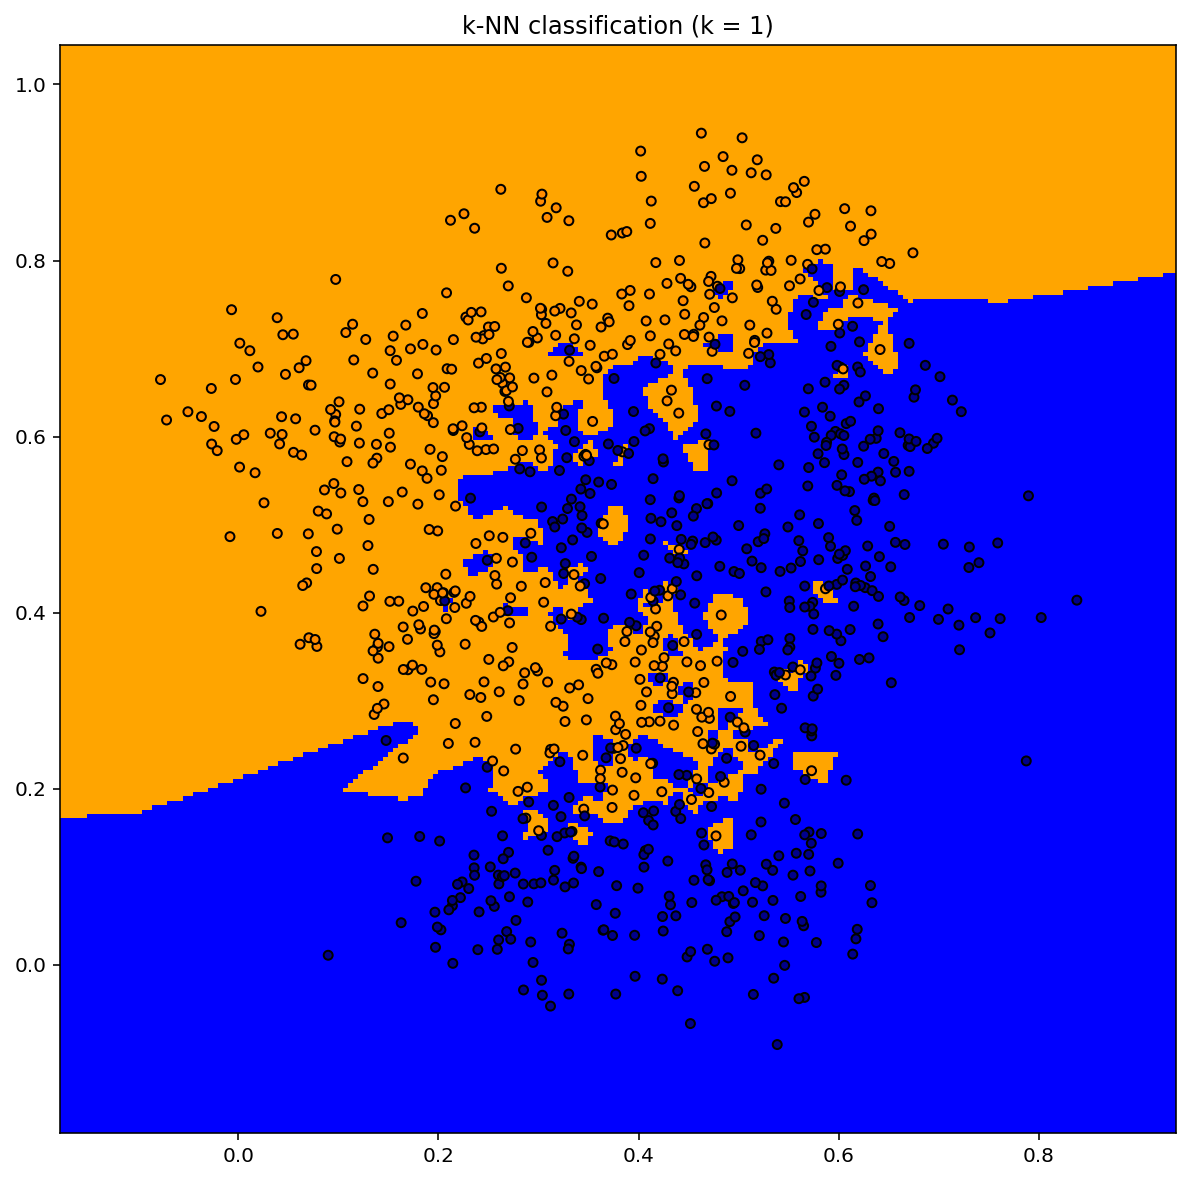

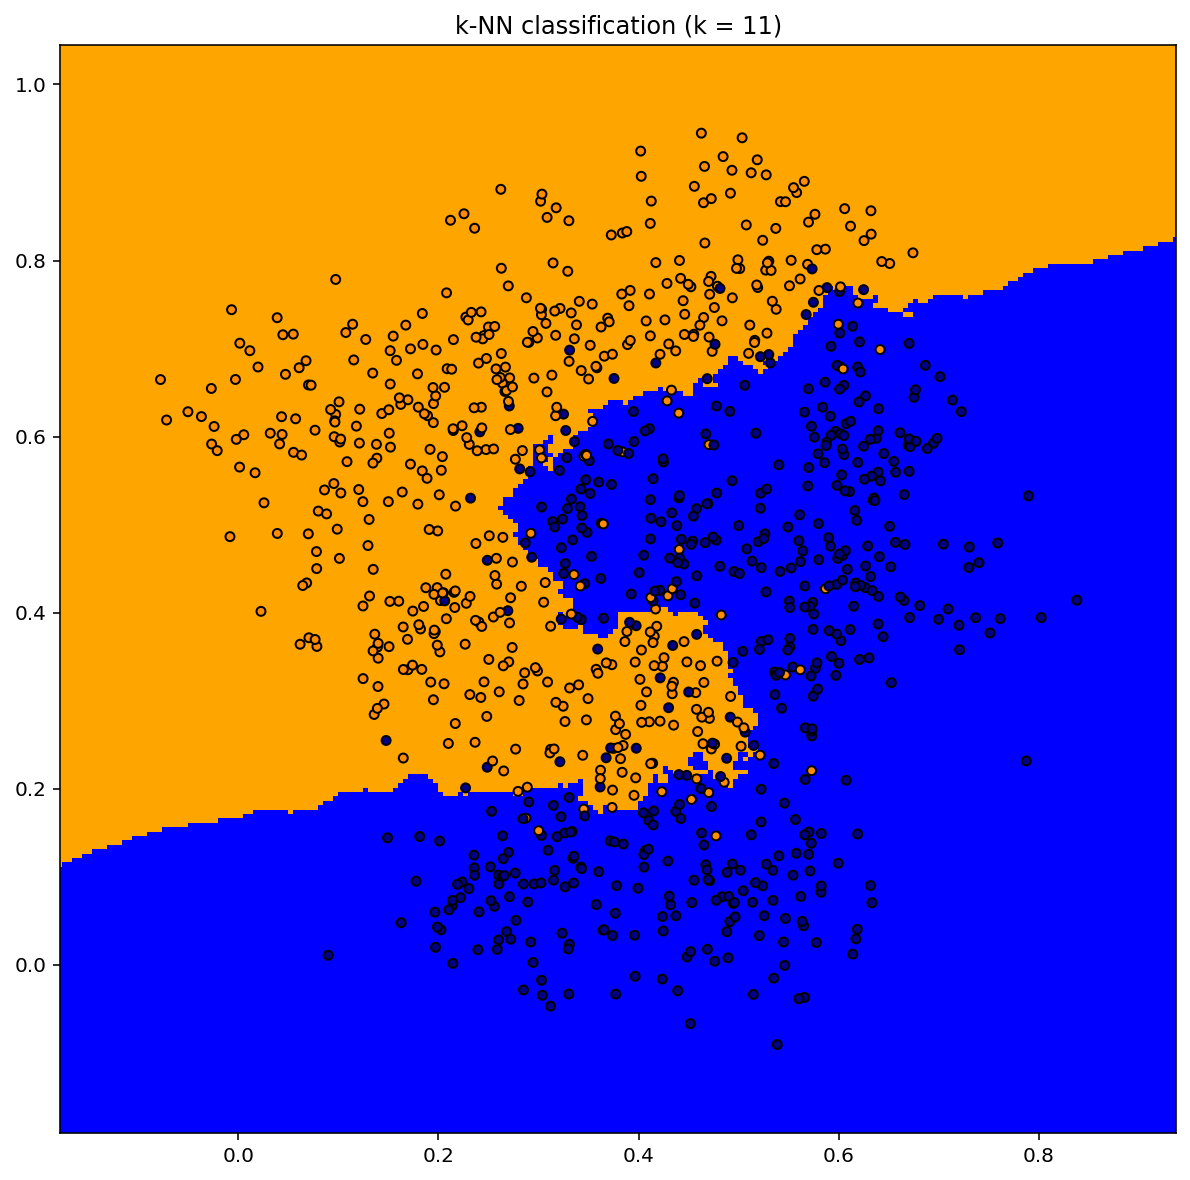

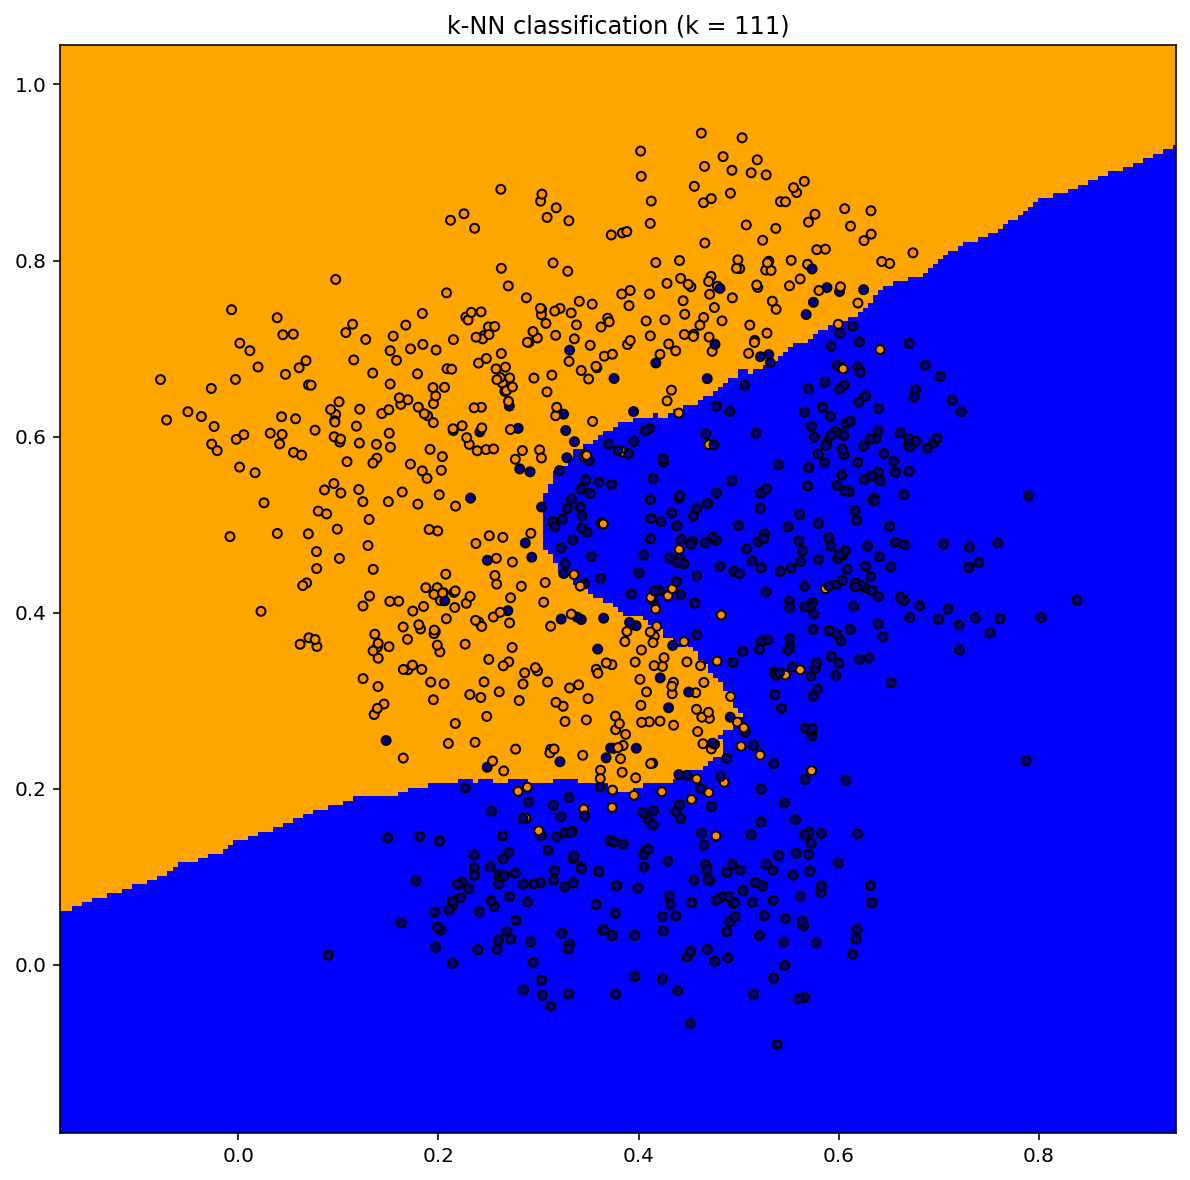

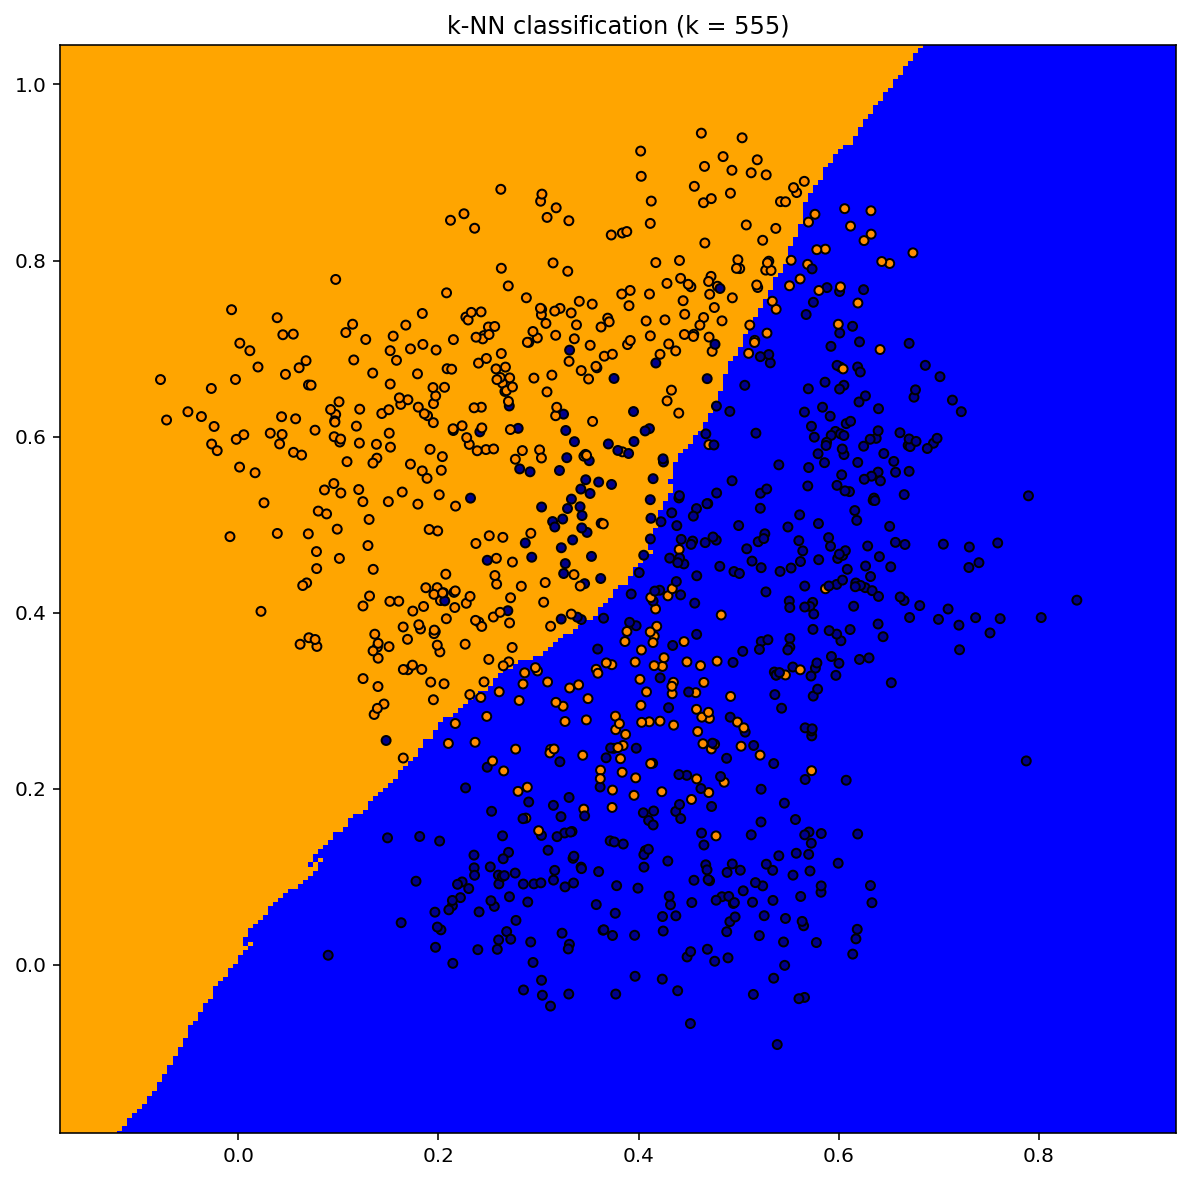

In [3]:
k_values = [1, 11, 111, 555]

for k in k_values: 
    # Build the k-NN classifier
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    h = .005  # step size in the mesh
    x_min, x_max = X['x1'].min() - .1, X['x1'].max() + .1
    y_min, y_max = X['x2'].min() - .1, X['x2'].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='nearest')

    # Plot also the training points
    plt.scatter(X['x1'], X['x2'], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("k-NN classification (k = {})".format(k))
    plt.show()

For small $k$, we get a very strange boundary that one would suspect wouldn't generalize well.  For large $k$, we get a very smooth boundary with many misclassifications.  We can rightly expect that there is some best value of $k$ that generalizes well beyond our data.  How do we find that?

The common practice is to _divide our data into a training set and a test set_.  We build our model with the training data and we test its performance with the testing data.  For our classification task, we will use the ```sklearn.metrics.accuracy_score``` as our performance measure.  It is the fraction of correct classifications.

We will now divide our data in half into a 500 point training set and a 500 point testing set.  The points are already shuffled, otherwise shuffling them would be an important step to avoid having all of one class in the training set and all of another class in the testing set. 

We can then try a range of $k$ values to see which has the highest accuracy for the test set.  (Note that poor testing with our training data would give perfect accuracy for $k = 1$ and generally decreasing accuracy for increasing $k$.)

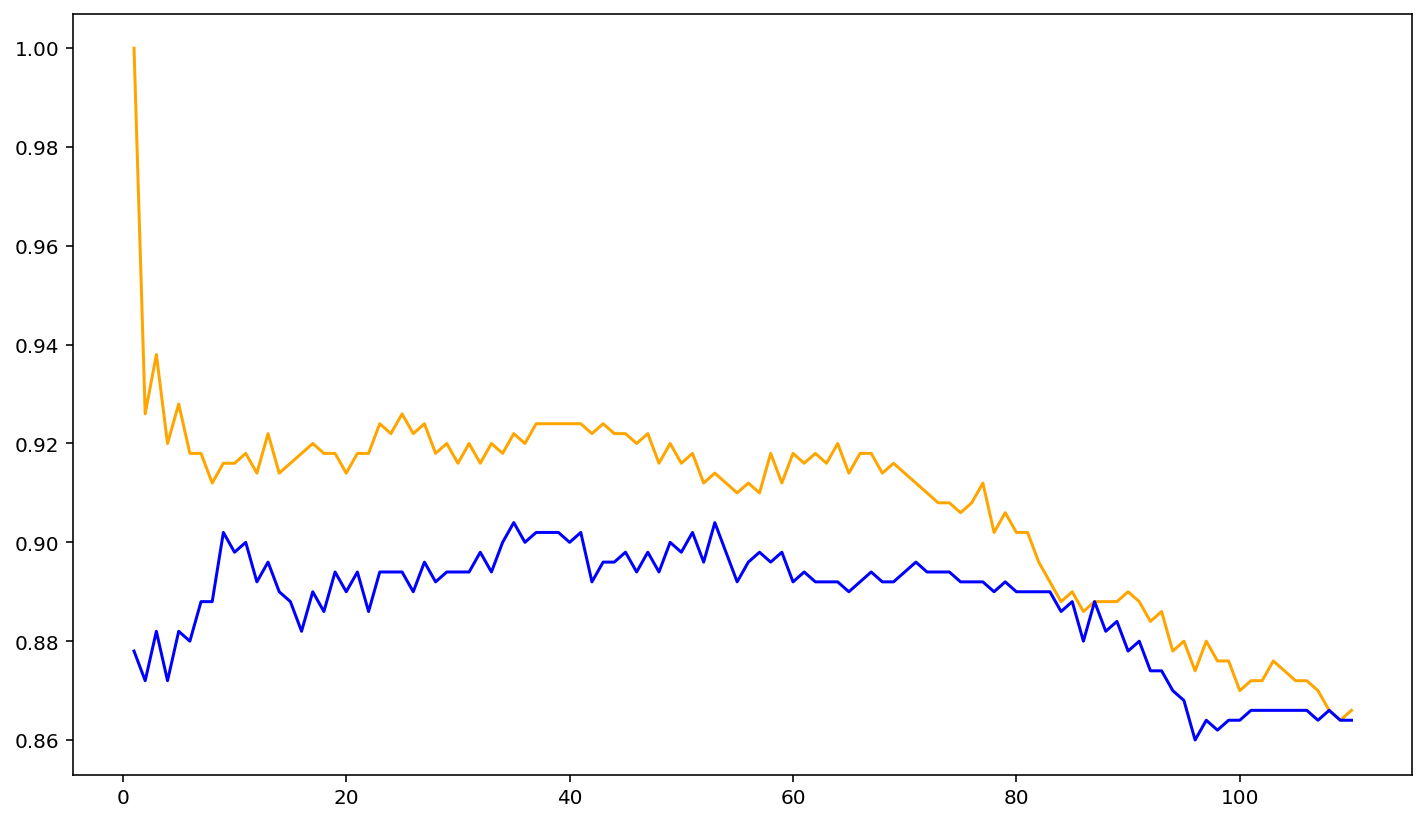

Parameter k=35 gave the maximum accuracy: 0.904


In [4]:
k_values = list(range(1, 111))

# Create input/output dataframe slices
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

def get_accuracy(k):
    # Build the k-NN classifier
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    # Compute predictions
    y_predict = clf.predict(X_test)
    return accuracy_score(y_test, y_predict)

def get_train_accuracy(k):
    # Build the k-NN classifier
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    # Compute predictions
    y_predict = clf.predict(X_train)
    return accuracy_score(y_train, y_predict)

acc_values = [get_accuracy(k) for k in k_values]
train_acc_values = [get_train_accuracy(k) for k in k_values]
plt.plot(k_values, train_acc_values, color = 'orange')
plt.plot(k_values, acc_values, color='blue')
plt.show()
best_index = np.argmax(acc_values)
print("Parameter k={} gave the maximum accuracy: {}".format(k_values[best_index], acc_values[best_index]))

This plot shows how our model has decreasing accuracy on the training set as $k$ increases, yet the accuracy on the testing set increases and then decreases, indicating a happy middle range.  If we smoothed this data, we'd see it peak in the 30s.  Any value in the upper 30s gives good accuracy for the test data.  Let's see what the k=35 boundary looks like.

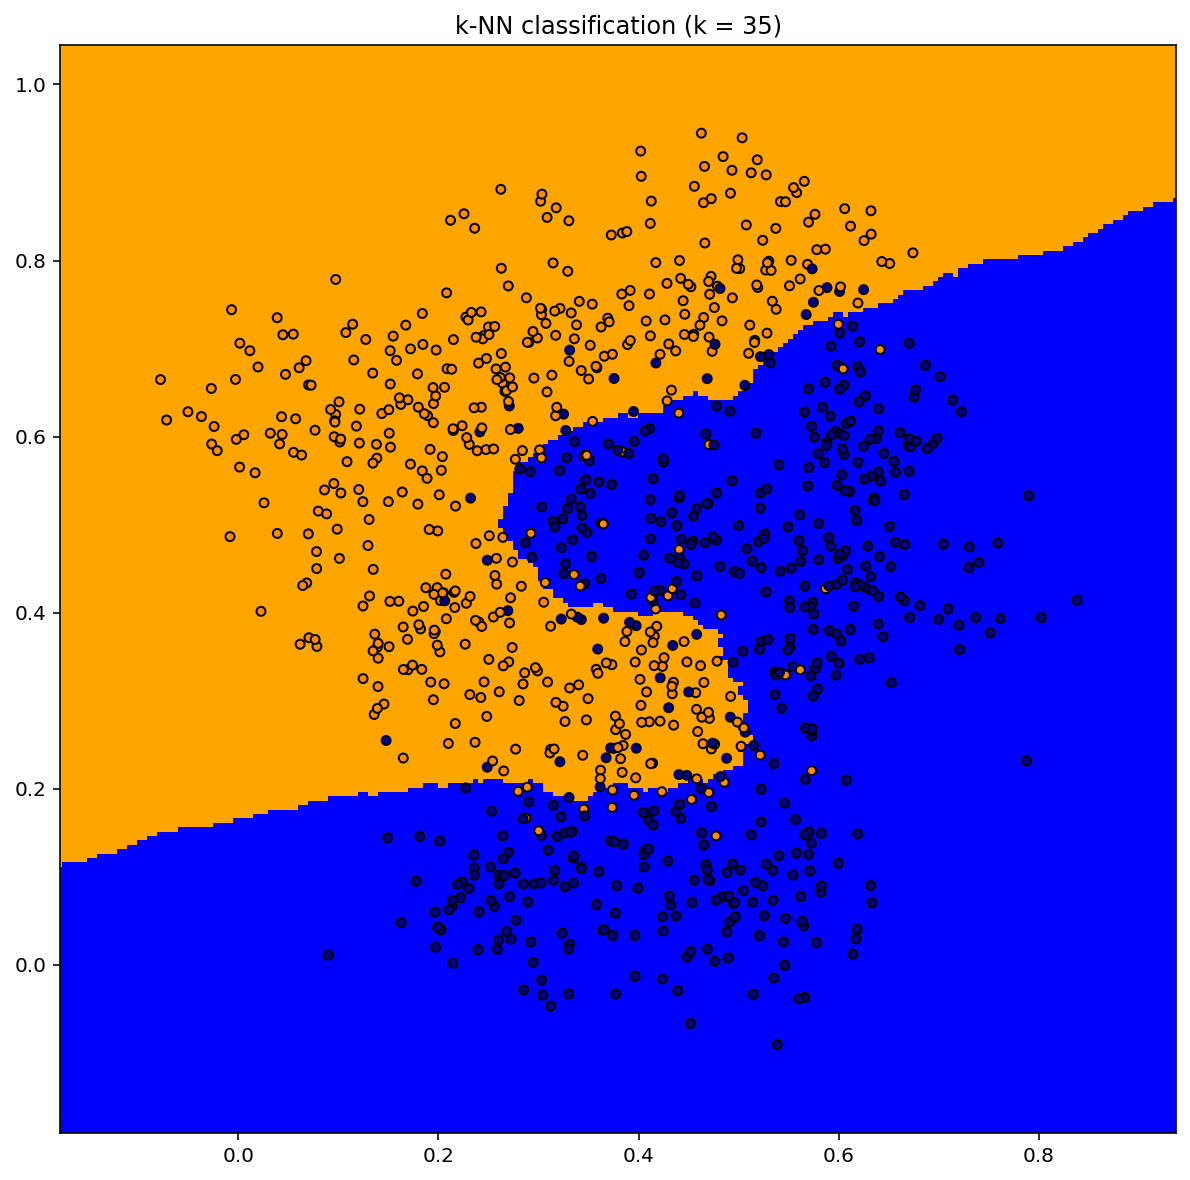

In [5]:
# Build the k-NN classifier
k = 35
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .005  # step size in the mesh
x_min, x_max = X['x1'].min() - .1, X['x1'].max() + .1
y_min, y_max = X['x2'].min() - .1, X['x2'].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='nearest')

# Plot also the training points
plt.scatter(X['x1'], X['x2'], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-NN classification (k = {})".format(k))
plt.show()

Here we see a relatively smooth boundary with inevitable classification error from the overlap of the source data distributions.

The main takeaway point here is that performance on the training dataset doesn't tell us how we should expect our model to perform on unseen data.  For this reason, we hold out a testing dataset from the training process and use it only to assess the generalizability of our model.  This is an important practice of a Data Scientist.

## Normalization

Since we're using Euclidean distance as our metric for "nearest" in k-NN, it's important that our data is of the same scale.  Watch what happens when we multiply ```x1``` times 100 and perform the same process.

Accuracy = 0.714


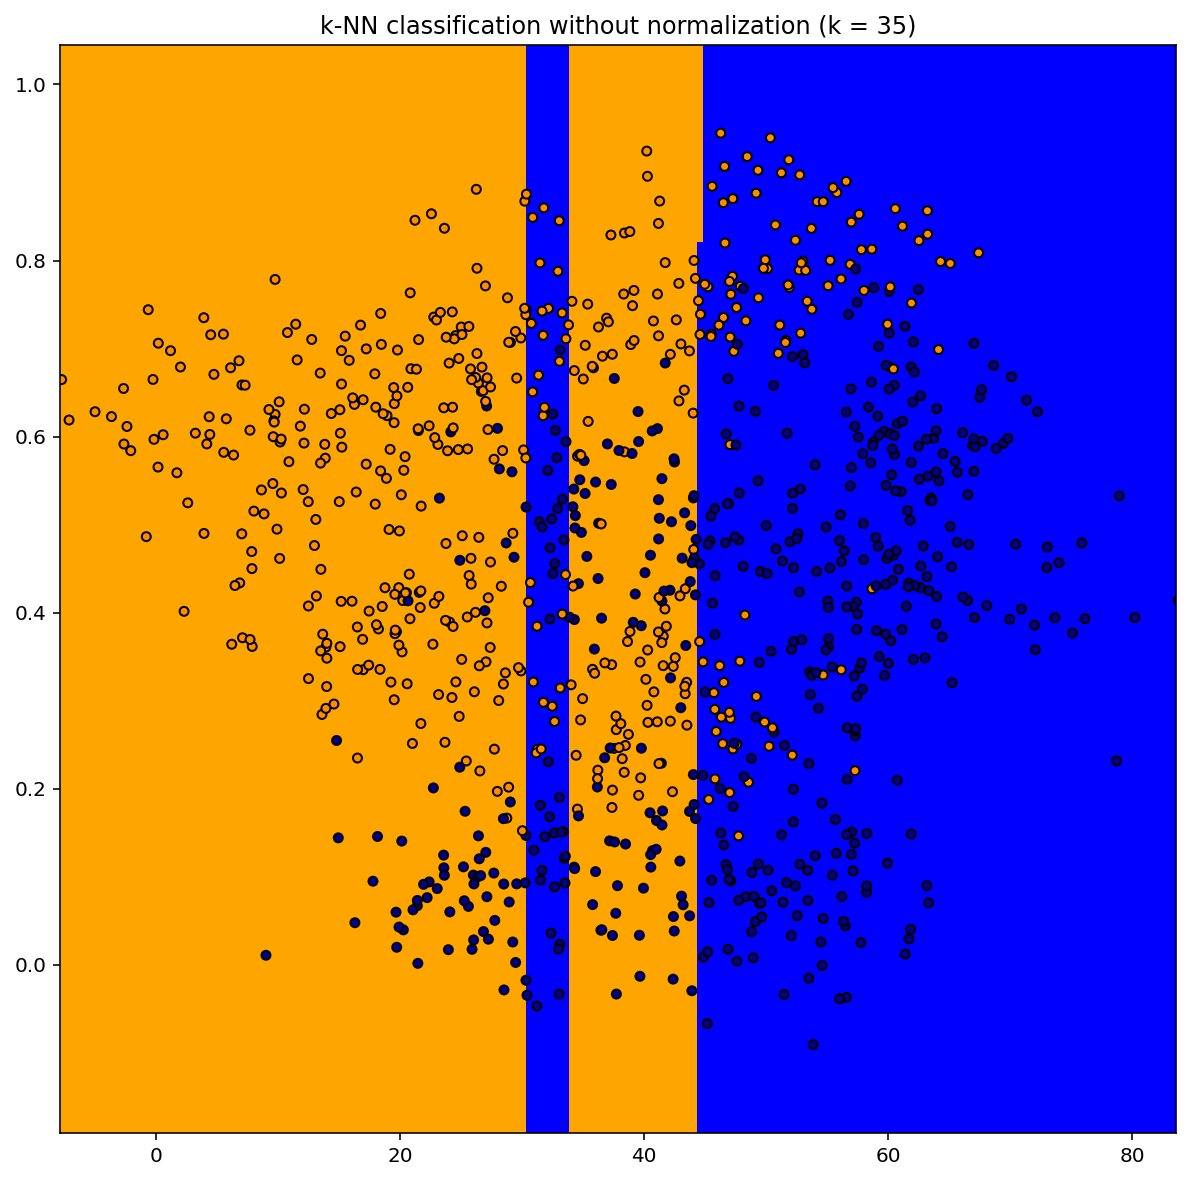

In [6]:
df['x1times100'] = df['x1'] * 100
X2 = df[['x1times100', 'x2']]
X_train, X_test, y_train, y_test = train_test_split(X2, y, train_size=0.5, random_state=0)

# Build the k-NN classifier
k = 35
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)
# Compute predictions
y_predict = clf.predict(X_train)
acc = accuracy_score(y_train, y_predict)

print('Accuracy =', acc)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .005  # step size in the mesh
x_min, x_max = X2['x1times100'].min() - .1, X2['x1times100'].max() + .1
y_min, y_max = X2['x2'].min() - .1, X2['x2'].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h * 100),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='nearest')

# Plot also the training points
plt.scatter(X2['x1times100'], X2['x2'], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-NN classification without normalization (k = {})".format(k))
plt.show()

With ```x1``` times 100 setting the values in the horizontal dimension relatively far apart, we see that the relatively close ```x1``` values are more determining of _nearest_. Accuracy has fallen from 90% to 71%, a significant loss.

Thus, is it also good practice to _normalize_ data before creating a k-NN model, or preprocessing data for use with the model.

Normalization can take different forms:
* scaling values so that the maximum - minimum = 1
* scaling and translating values to the range $[0, 1]$ or $[-0.5, 0.5]$
* for normal (a.k.a. Gaussian) distributions, scaling and translating to be mean 0 and standard deviation 1. This is called _standardization_.
* transformation to percentiles

Whatever the method, the basic idea is to transform the data so that no one dimension of the data has excessive influence on what it means to be nearest.

In summary, when applying k-NN for classification:
* Normalize your input data.
* Map your output classes/categories to 0-based indices.
* Split your data into training and testing sets.
* Perform k-NN on training data for a range of $k$ values, assessing accuracy with the testing data to find the best $k$.
* Predict classification on new data by first normalizing it exactly as you normalized your data.
* Map your predictions back to your original classes/categories.

Let's now see the entire process with visualization as above for a new two-class dataset.


                 x1            x2
count  10000.000000  10000.000000
mean     -46.236768     -0.462488
std        2.906567      0.028978
min      -52.461559     -0.524602
25%      -48.719696     -0.487313
50%      -46.263362     -0.462583
75%      -43.745542     -0.437293
max      -40.009191     -0.401922
           x1        x2    y
id                          
0  -50.335346 -0.440816  bar
1  -47.063696 -0.479325  bar
2  -50.012562 -0.462413  bar
3  -49.374007 -0.442351  bar
4  -42.125478 -0.428049  bar
5  -41.479471 -0.442391  foo
6  -46.589062 -0.480678  bar
7  -50.023813 -0.506963  foo
8  -47.188830 -0.440717  foo
9  -52.024189 -0.447853  bar
After scaling:
         x1        x2
0  0.170748  0.682963
1  0.433481  0.369072
2  0.196669  0.506923
3  0.247949  0.670449
4  0.830049  0.787031
5  0.881928  0.670127
6  0.471597  0.358042
7  0.195766  0.143786
8  0.423432  0.683768
9  0.035123  0.625605
After class-encoding:
         x1        x2  y
0  0.170748  0.682963  0
1  0.433481  0.36

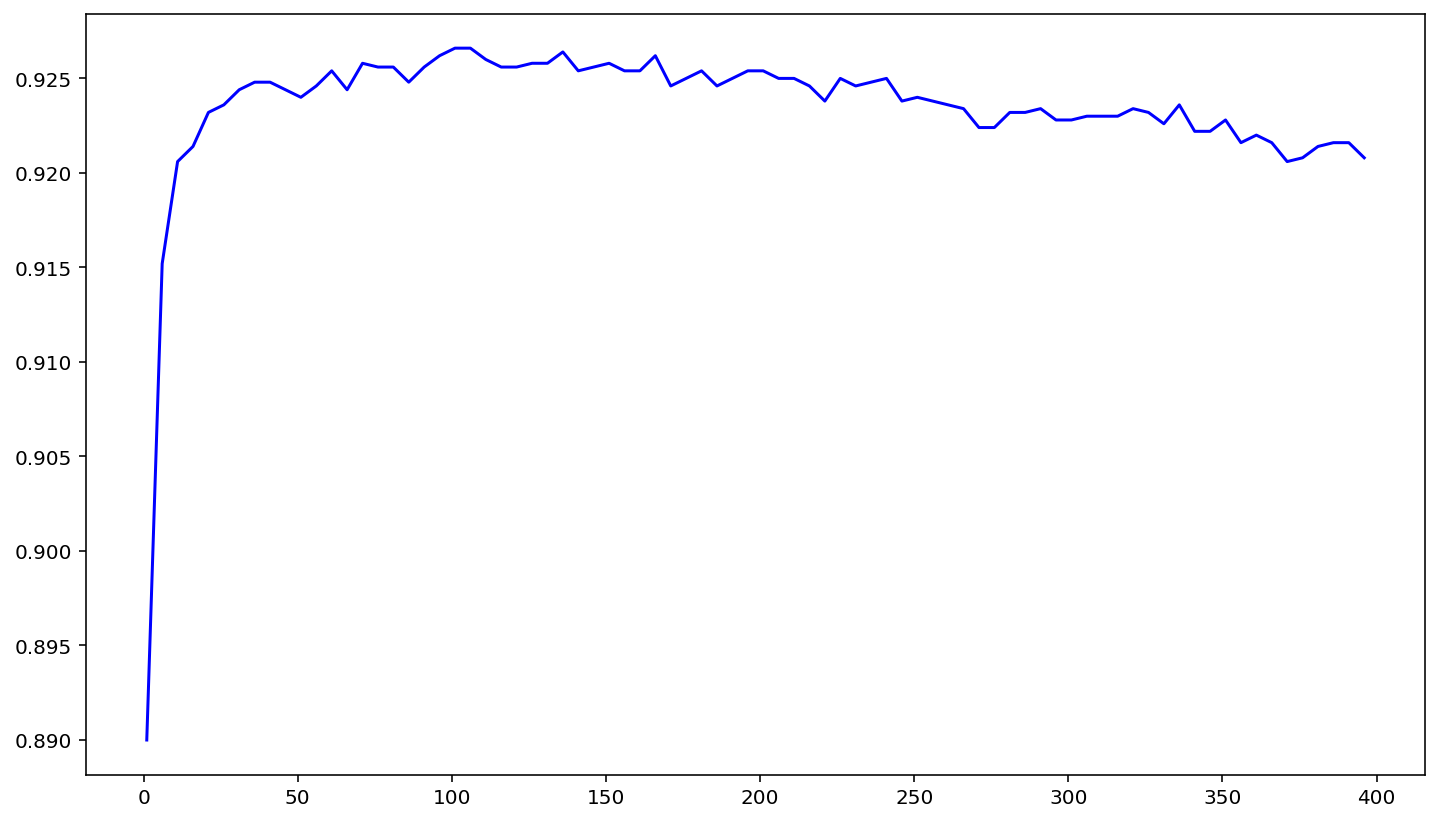

Parameter k=101 gave the maximum accuracy: 0.9266


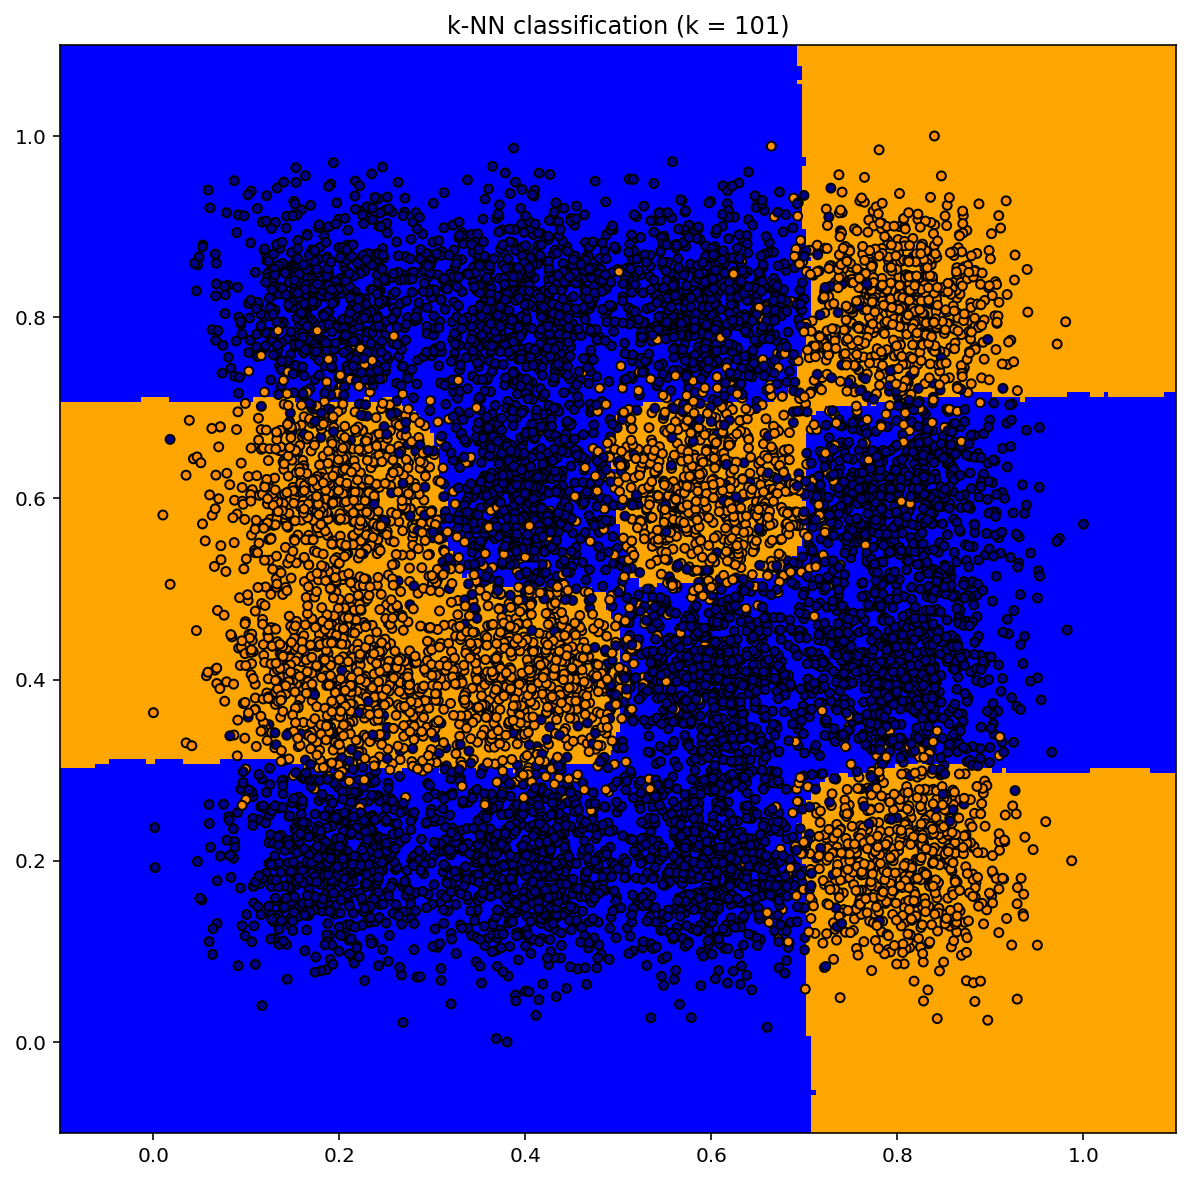

Target input for prediction:  [-49, -0.45]
Scaled inputs for prediction from our model: [[0.277984   0.60810338]]
Predicted class index: [0]
Class index mapped to class prediction: bar


In [7]:
# Load example data
df = pd.read_csv('http://cs.gettysburg.edu/~tneller/ds256/data/hw10/ex10-1.csv', index_col='id')
print(df.describe())
print(df.head(10))

# Create a normalization of x1, x2
from sklearn import preprocessing

input_cols = ['x1','x2']
x = df[input_cols].values  # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=input_cols)
print("After scaling:")
print(df_scaled.head(10))

# Create a mapping of all unique y class/category values to 0, 1, ...
classes = df.y.unique()
class_map = {c : i for i, c in enumerate(classes)}
df_scaled['y'] = df['y'].map(class_map)
print("After class-encoding:")
print(df_scaled.head(10))

# Divide into train, test sets
X = df_scaled[['x1', 'x2']]
y = df_scaled['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

# Build k-NN models and assess accuracy
k_values = list(range(1, 400, 5))
acc_values = [get_accuracy(k) for k in k_values]
plt.plot(k_values, acc_values, color='blue')
plt.show()
best_index = np.argmax(acc_values)
print("Parameter k={} gave the maximum accuracy: {}".format(k_values[best_index], acc_values[best_index]))

# Build our best k-NN model and plot
k = 101  # Note: Some use k = sqrt(n) as a default for a dataset of size n
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .005  # step size in the mesh
x_min, x_max = X['x1'].min() - .1, X['x1'].max() + .1
y_min, y_max = X['x2'].min() - .1, X['x2'].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='nearest')

# Plot also the training points
plt.scatter(X['x1'], X['x2'], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-NN classification (k = {})".format(k))
plt.show()

# Perform a prediction for x1 = -49, x2 = -0.45
target = [-49, -0.45]
print("Target input for prediction: ", target)
target_scaled = min_max_scaler.transform([target])
print("Scaled inputs for prediction from our model:", target_scaled)
class_predict = clf.predict(target_scaled)
print("Predicted class index:", class_predict)
print("Class index mapped to class prediction:", classes[class_predict[0]])

## The Bias-Variance Spectrum

There are a number of criteria used for judging the characteristics of different machine learning and statistical models:
* _bias_ - How much is a model constrained to model only a small subset of functions?
* _variance_ - How much can a change to the output of a single training example affect the learned model?
* _interpretability_ - How easy is it to interpret what the model has learned?  How well does it aid human explanation of predictions?
* _performance_ - How well accurately does a model predict for complex functions?

We will observe that models tend to fall along a spectrum from one extreme to another.  Let us observe what we know of k-NN classification:
* low-bias - k-NN makes no particular commitment to a functional form for classification.  It predicts what nearby data predicts.
* high-variance - For low $k$, a single outlying point can affect the predictions for a large region.
* low-interpretability - For higher dimensions that are difficult to visualize, we cannot learn any useful generalized information about the model.  The model itself is _local_ in nature and only reflects local data, not general patterns.
* high-performance - k-NN properly applied does a good job of prediction as long as we can handle the computational demands.

Contrast this with linear regression:
* high-bias - Linear regression assumes a linear form to _any_ function one applies it to.  One can perform transformations to allow non-linear regression using linear regression, but linear regression itself assumes linear relationships between variables.
* low_variance - A single point generally has little affect on the least-squares error, as it is only one point among many contributing to that error measure.
* high-interpretability - The simple model is easy to explain. One can talk of the significance of different variables, their relative contribution to the prediction, etc.
* low-performance - Beyond functions that can be transformed to linear relationships, linear regression performs poorly as a predictor.

In general, classical statistical methods tend to reside at the high-bias, low-variance, high-interpretability, low-performance end of the spectrum.  Modern statistical and machine learning methods lie along the spectrum with k-NN, support vector machines (SVMs), and artificial neural networks (ANNs) residing at the low-bias, high-variance, low-interpretability, high-performance end of the spectrum.

It will become important to gain an understanding of a spectrum of modeling options depending on your application, especially considering the relative importance of accurate prediction to interpretability.


# In Class

Together in class, you will seek to build models for each of the given data sets using the techniques above.

**Exercise 1:** Model the data of [ic10-1.csv](http://cs.gettysburg.edu/~tneller/ds256/data/hw10/ic10-1.csv) with k-nearest neighbor classification as above.  Split your training and test data 50/50, train your k-NN model on the training data, and choose a $k$ yielding good accuracy with the testing data.  Predict the classification of the target values provided below.

In [1]:
targets = [[41.99, 100], [42.003, 106], [42.009, 109]]



**Exercise 2:** Model the data of [ic10-2.csv](http://cs.gettysburg.edu/~tneller/ds256/data/hw10/ic10-2.csv) with k-nearest neighbor classification as above.  Split your training and test data 50/50, train your k-NN model on the training data, and choose a $k$ yielding good accuracy with the testing data.  Predict the classification of the target values provided below.  Note here that there are more than two class values.

In [2]:
targets = [[4003, -9.96], [4003, -9.98], [6000, -9.98]]



## Homework


**Exercise 1:** Model the data of [hw10-1.csv](http://cs.gettysburg.edu/~tneller/ds256/data/hw10/hw10-1.csv) with k-nearest neighbor classification as above.  Split your training and test data 50/50, train your k-NN model on the training data, and choose a $k$ yielding good accuracy with the testing data.  Predict the classification of the target values provided below.

In [2]:
targets = [[10123, -49.9], [10630, -49.4], [10630, -49.9], [10123, -49.4]]



**Exercise 2:** Model the data of [hw10-2.csv](http://cs.gettysburg.edu/~tneller/ds256/data/hw10/hw10-2.csv) with k-nearest neighbor classification as above.  Split your training and test data 50/50, train your k-NN model on the training data, and choose a $k$ yielding good accuracy with the testing data.  Predict the classification of the target values provided below.  Note here that there are more than two class values.

In [1]:
targets = [[-9.998, 100.06], [-9.993, 100.04], [-9.996, 100.02], [-9.993, 100.02], [-9.996, 100.04], [-9.998, 100.06]]



(end of homework)